# Import libraries

In [1]:
import pandas as pd
import numpy as np
import re
import pikepdf
import tabula
import matplotlib.pyplot as plt
import shutil
import config
import os

## Month start and end date

In [2]:
start_date = config.MONTH_START #'2022-05-01'
end_date = config.MONTH_END #'2022-05-31'
print('start_date: {}, end_date: {}'.format(start_date, end_date))

start_date: 01-May-2022, end_date: 31-May-2022


## Rule based grouping of expenses
#### ! Automate this part using NLP

In [3]:
merchant_mapping = {}
merchant_mapping['Credit Card Bill'] = ['CRED']
merchant_mapping['Transfer'] = ['DOOSA(\s+)?SRIKANTH','MITTAPELLY(\s+)?NAVEEN','SHEFALI', 'VINOD', 'DOOSA(\s+)?GANESH','GANESH(\s+)?DOOSA']
merchant_mapping['Groceries'] = ['BIGBASKET','DMART','SHOPPING LAND SUPER', 'SWIGGY','ZOMATO', 'ZEPTO','MUTTON STALL', 'VEGETABLE', 'EGG', 'BREAKFAST', 'IDLI', 'BYDBYT', 'LUNCH', 'SNACKS', 'DINNER', 'COCONUT', '(ZEPTO)?GEDDIT(\s+)?CONVENIENCE']
merchant_mapping['Investment'] = ['RD INSTALLMENT','RD THROUGH MOBILE', 'BSE LIM','CHILUKA SRAVAN KUMAR','PUPPALA(\s+)?SINDHUJA','SRINIVASDOOSA','LAKH CHIT?','DOOSA KAVITHA', 'CHIT', 'SNEHA VINAY','NEXTBILLIONTECHNOLOG', 'GROWW','(STOCKS)?213391890638']
merchant_mapping['Rent'] = ['VISHU KUMAR KURA']
merchant_mapping['Health'] = ['RHEUMATOLOGY','APOLLO','PHARMACY','DIAGNOSTICS?','PHARMEASY','MEDICINES?']
merchant_mapping['Entertainment'] = ['BOOKMYSHOW','NETFLIX']
merchant_mapping['Bills'] = ['UTILITY BILL','BLUEMALIBU','BHARTI AIRTEL','VODAFONE IDEA', '(ELECTRICITY)?BBPSBP']
merchant_mapping['Transport'] = ['BIKE','PARKING','SERVICE(\s+)?STATION?','FUEL','MAKEMYTRIP','GOIBIBO','OLA','UBER']
merchant_mapping['Shopping'] = ['AMAZON','LAPTOP','DECATHLON','FLIPKART','WASHING(\s+)?MACHINE']
merchant_mapping['EMI'] = ['EMI','IGST']
merchant_mapping['Personal Care'] = ['SALONE','MENS','GYM']

In [25]:
def preprocess_statements(statements):
    for statement in statements:
        if statement == 'DEBIT_HDFC':
            # Read HDFC Debit card data
            if config.DEBIT_HDFC_ORIGINAL.endswith('.xls') or config.DEBIT_HDFC_ORIGINAL.endswith('.csv'):
                hdfc_debit = pd.DataFrame(pd.read_excel(config.DEBIT_HDFC_ORIGINAL))
                hdfc_debit.to_csv(config.DEBIT_HDFC, index=False)
            else:
                raise Exception("DEBIT_HDFC should be in XLS or CSV format.")
        elif statement == 'CREDIT_HDFC':
            # Read HDFC Credit card data
            pdf = pikepdf.open(config.CREDIT_HDFC_ORIGINAL, password=config.PASSWORDS[statement])
            pdf.save(config.TEMP)
            tabula.convert_into(config.TEMP, config.CREDIT_HDFC, output_format="csv",lattice=True, pages='all')
            os.remove(config.TEMP)
        elif statement == 'DEBIT_STD':
            #read standard chartered
            if config.DEBIT_STD_ORIGINAL.endswith('.csv'):
                shutil.copy(config.DEBIT_STD_ORIGINAL, config.DEBIT_STD)
            else:
                raise Exception("DEBIT_STD should be in CSV format.")
        elif statement == 'CREDIT_CITI':
            # Read citi bank credit card
            pdf = pikepdf.open(config.CREDIT_CITI_ORIGINAL, password=config.PASSWORDS[statement])
            pdf.save(config.TEMP)
            tabula.convert_into(config.TEMP, config.CREDIT_CITI, output_format="csv",stream=True, pages='all')
            os.remove(config.TEMP)

def mapping(row,col):
    for expense_type in merchant_mapping.keys():
        for expense in merchant_mapping[expense_type]:
            match  = re.search(expense.lower(), row[col].lower())
            if match:
                return expense_type, match.group(0).upper()
    return 'MISC/Unknown', row[col]
    
    
def extract_transactions(statement, df):
    # extract transactions
    if statement == 'DEBIT_HDFC':
        start_index = df.shape[0]
        end_index = 0
        for index, row in df.iterrows():
            if row[0]=='Date':
                start_index = index
            if index>start_index and  row[0] is np.nan:
                end_index = index-1
                break
        print('start_index : {}, end_index : {}'.format(start_index, end_index))
        return start_index,end_index  

    
def combine_statements(statements):
    for statement in statements:
        if statement == 'DEBIT_HDFC':
            hdfc_debit = pd.read_csv(config.DEBIT_HDFC)
            start_index, end_index = extract_transactions(statement, hdfc_debit)
            hdfc_debit.columns = hdfc_debit.iloc[start_index].to_list()
            hdfc_debit = hdfc_debit.iloc[start_index+2:end_index]
            hdfc_debit.reset_index(drop=True, inplace=True)
            hdfc_debit['Date'] = pd.to_datetime(hdfc_debit['Date'], format='%d/%m/%y')
            #hdfc_debit = hdfc_debit[(hdfc_debit['Date']>=start_date)&(hdfc_debit['Date']<=end_date)&hdfc_debit['Withdrawal Amt.']]
            hdfc_debit[['Expense Type','Expense']] = hdfc_debit.apply(mapping,col='Narration', axis=1, result_type="expand")
            hdfc_debit = hdfc_debit[['Date','Expense Type','Expense','Withdrawal Amt.']][hdfc_debit['Expense Type']!='Credit Card Bill']
            hdfc_debit.reset_index(drop=True, inplace=True)
            hdfc_debit.sort_values(['Expense Type','Expense'], ascending=True, ignore_index=True, inplace=True)
            hdfc_debit.rename(columns={'Withdrawal Amt.':'Amount'},inplace=True)
            hdfc_debit['Amount']= pd.to_numeric(hdfc_debit['Amount'])            
        elif statement == 'CREDIT_HDFC':
            # Read HDFC CREDIT
            hdfc_credit = pd.read_csv(config.CREDIT_HDFC, skiprows=1, header=None,encoding='cp1252',on_bad_lines='skip')
            hdfc_credit.dropna(how='all', inplace=True)
            hdfc_credit.dropna(subset=[0],inplace=True)
            hdfc_credit.drop(columns=[2,3,5],inplace=True)
            hdfc_credit.reset_index(drop=True,inplace=True)
            hdfc_credit.columns = ['Date', 'Transaction Description', 'Amount']
            hdfc_credit['Date'] = pd.to_datetime(hdfc_credit['Date'],dayfirst=True, errors='coerce')
            #hdfc_credit = hdfc_credit[(hdfc_credit['Date']>=start_date)&(hdfc_credit['Date']<=end_date)]
            hdfc_credit['Amount']= hdfc_credit['Amount'].str.replace(',','')
            hdfc_credit[['Amount','Credit/Debit']] = hdfc_credit['Amount'].str.extract(r'(\d+\.?\d*)\s*([a-zA-Z]*)', expand=True)
            hdfc_credit['Amount']= pd.to_numeric(hdfc_credit['Amount'])
            duplicates = hdfc_credit.Amount.duplicated(keep=False)
            credit_count = hdfc_credit.loc[duplicates, :]['Credit/Debit']=='Cr'
            c = credit_count.value_counts()
            if c.nunique()==1:
                hdfc_credit = hdfc_credit.drop(duplicates[duplicates].index)
            elif c.nunique()==0:
                pass
            else:
                raise Exception()
            hdfc_credit.reset_index(drop=True, inplace=True)
            hdfc_credit = hdfc_credit[hdfc_credit['Credit/Debit']!='Cr']
            hdfc_credit[['Expense Type','Expense']] = hdfc_credit.apply(mapping,col='Transaction Description', axis=1, result_type="expand")
            
        elif statement == 'DEBIT_STD':
            std_debit = pd.read_csv(config.DEBIT_STD, sep=',', skiprows=4)
            std_debit.rename(columns={'\tDate':'Date'},inplace=True)
            std_debit['Date'] = std_debit.Date.str.replace('\t','')
            std_debit['Date'] = pd.to_datetime(std_debit['Date'],dayfirst=True,errors='coerce')
            #std_debit = std_debit[(std_debit['Date']>=start_date)&(std_debit['Date']<=end_date)]
            std_debit[['Expense Type','Expense']] = std_debit.apply(mapping, col='Transaction', axis=1, result_type="expand")
            std_debit.rename(columns={'Withdrawal':'Amount'}, inplace=True)
            std_debit['Amount']= std_debit['Amount'].str.replace(',','')
            std_debit['Amount']= pd.to_numeric(std_debit['Amount'])
            # Handle refunds
            std_debit['Deposit']= std_debit['Deposit'].str.replace(',','')
            std_debit['Deposit']= pd.to_numeric(std_debit['Deposit'])
            std_debit.drop(std_debit[std_debit['Amount'].isin(std_debit['Deposit'])].index,axis=0,inplace=True)
            std_debit.groupby(['Expense Type','Expense']).sum()
            std_debit.drop('Deposit', axis=1, inplace=True)
        elif statement == 'CREDIT_CITI':
            citi_credit = pd.read_csv(config.CREDIT_CITI, encoding='cp1252',on_bad_lines='skip')
            citi_credit.dropna(axis=1, how='all', inplace=True)
            citi_credit.dropna(how='all',inplace=True)
            citi_credit.rename(columns={'Amount (in Rs)':'Amount'},inplace=True)
            citi_credit[['Amount','Credit/Debit']] = citi_credit['Amount'].str.replace('CR',' Cr').str.extract(r'(\d+\.?\d*)\s*([a-zA-Z]*)', expand=True)
            citi_credit['Amount']= pd.to_numeric(citi_credit['Amount'])
            duplicates = citi_credit.Amount.duplicated(keep=False)
            credit_count = citi_credit.loc[duplicates, :]['Credit/Debit']=='Cr'
            c = credit_count.value_counts()
            if c.nunique()==1:
                citi_credit = citi_credit.drop(duplicates[duplicates].index)
            elif c.nunique()==0:
                pass
            else:
                raise Exception()
            citi_credit.reset_index(drop=True, inplace=True)
            citi_credit = citi_credit[citi_credit['Credit/Debit']!='Cr']
            citi_credit[['Expense Type','Expense']] = citi_credit.apply(mapping,col='Transaction Details', axis=1, result_type="expand")
            citi_credit.reset_index(drop=True, inplace=True)
            citi_credit.drop(columns='Reference no',inplace=True)
   
    transactions = pd.concat([hdfc_debit, hdfc_credit, std_debit, citi_credit])
    transactions.reset_index(drop=True,inplace=True)
    hdfc_credit['Amount']= pd.to_numeric(hdfc_credit['Amount'])
    transactions.Amount.fillna(0,inplace=True)
    return transactions
            
            
def plot(transactions):
    gp = transactions.groupby(['Expense Type']).sum()
    fig = plt.figure(figsize = (14, 7))
    # creating the bar plot
    plt.bar(gp.index, gp.Amount, color ='maroon', width = 0.4)
    plt.xlabel("Expense Type")
    plt.ylabel("Amount")
    plt.title(f"Amount spent for {config.MONTH_YEAR}")
    plt.xticks(rotation=90)
    plt.show()
    plt.savefig(config.EXPENSES_PLOT)

start_index : 19, end_index : 86
                                                                    Amount
Expense Type  Expense                                                     
Bills         BBPSBP                                               1514.00
              BHARTI AIRTEL                                        1178.82
              BLUEMALIBU                                           3056.00
EMI           EMI                                                 28326.69
              IGST                                                  463.93
Entertainment NETFLIX                                               973.00
Groceries     BIGBASKET                                             501.35
              COCONUT                                                35.00
              DINNER                                                 40.00
              DMART                                                2508.95
              GEDDIT CONVENIENCE                                   

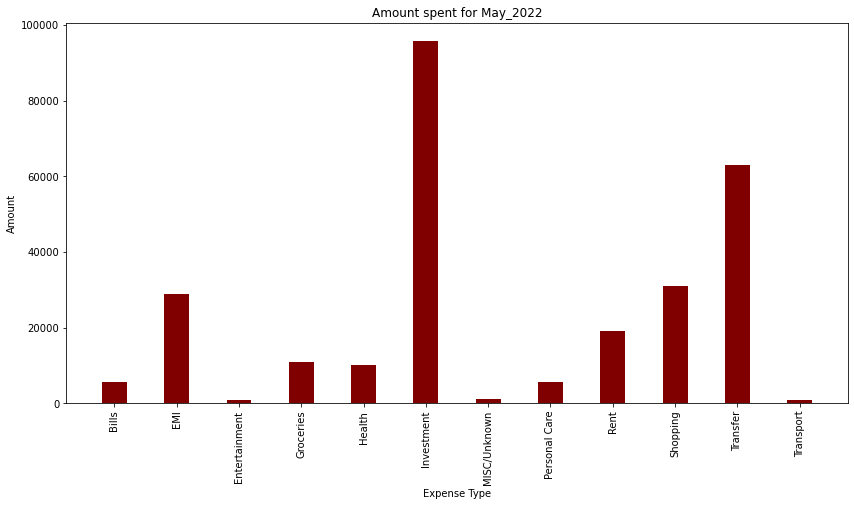

<Figure size 432x288 with 0 Axes>

In [26]:
if __name__=='__main__':
    preprocess_statements(config.STATEMENTS)
    transactions = combine_statements(config.STATEMENTS)
    transaction_gp = transactions.groupby(['Expense Type']).sum()
    transaction_gp.to_csv(config.ALL_TRANSACTIONS)
    print(transactions.groupby(['Expense Type','Expense']).sum())
    plot(transactions)